# Polar Coding Notebook

In [1]:
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


Helper Functions

In [2]:
def polar_transform(u):
    N = len(u)
    if N == 1:
        return u.copy()

    u_even = u[0:N:2]
    u_odd = u[1:N:2]

    x_upper = polar_transform((u_even ^ u_odd) % 2)
    x_lower = polar_transform(u_odd)
    return np.concatenate([x_upper, x_lower])


def bhattacharyya_parameter(p, N):
    Z = np.array([2 * np.sqrt(p * (1 - p))])
    while len(Z) < N:
        Z_next = []
        for z in Z:
            Z_next.append((2 * z) - (z ** 2))  # Upper channel
            Z_next.append(z ** 2) # Lower channel
        Z = np.array(Z_next)
    return Z


def select_frozen_bits(N, K, p):
    Z = bhattacharyya_parameter(p, N)
    indices = np.argsort(Z)
    info_index = indices[:K]
    frozen = np.ones(N, dtype=bool)
    frozen[info_index] = False
    return frozen, info_index


def polar_encode(msg, frozen_mask, info_index, u_frozen):
    N = len(frozen_mask)
    K = len(info_index)
    assert len(msg) == K

    if u_frozen is None:
        u_frozen = np.zeros(N, dtype=np.int8)
    else:
        u_frozen = np.array(u_frozen, dtype=np.int8)

    u = np.array(u_frozen, dtype=np.int8)
    info_pos = np.sort(np.array(info_index, dtype=int))
    u[info_pos] = np.array(msg, dtype=np.int8)
    x = polar_transform(u)

    # u is only returned for debugging purposes
    return x, u


def successive_cancellation_decode(llr, frozen, u_frozen):
    # llr is the log-likelihood ratio input

    if u_frozen is None:
        u_frozen = np.zeros(len(frozen), dtype=np.int8)
    N = len(llr)
    frozen = np.array(frozen, dtype=bool)
    u_frozen = np.array(u_frozen, dtype=np.int8)

    def sc_decode_recursive(llr_sub, frozen_sub, u_frozen_sub):
        n = len(llr_sub)
        if n == 1:
            if frozen_sub[0]:
                return np.array([u_frozen_sub[0]], dtype=np.int8)
            else:
                return np.array([0 if llr_sub[0] >= 0 else 1], dtype=np.int8)
        
        # Split arrays for left and right parts
        n2 = n // 2
        llr_left = llr_sub[:n2]
        llr_right = llr_sub[n2:]

        # Compute LLRs for upper part
        llr_upper = np.sign(llr_left * llr_right) * np.minimum(np.abs(llr_left), np.abs(llr_right))
        frozen_upper = frozen_sub[:n2] & frozen_sub[n2:]
        frozen_upper = frozen_sub[:n2]
        u_frozen_upper = u_frozen_sub[:n2]
        uhat_upper = sc_decode_recursive(llr_upper, frozen_upper, u_frozen_upper)

        # Compute LLRs for lower part
        sign_term = (1 - 2 * uhat_upper)
        llr_lower = llr_right + sign_term * llr_left
        frozen_lower = frozen_sub[n2:]
        u_frozen_lower = u_frozen_sub[n2:]
        uhat_lower = sc_decode_recursive(llr_lower, frozen_lower, u_frozen_lower)

        # Combine results: u_upper = uhat_upper ^ uhat_lower, u_lower = uhat_lower
        u_upper = (uhat_upper ^ uhat_lower).astype(np.int8)
        u_combined = np.concatenate([u_upper, uhat_lower]).astype(np.int8)
        return u_combined
    
    uhat = sc_decode_recursive(np.array(llr, dtype=float), np.array(frozen, dtype=bool), np.array(u_frozen, dtype=np.int8))
    return uhat

Channels

In [3]:
def bsc(x, p):
    flips = (np.random.rand(len(x)) < p).astype(np.int8)
    return x ^ flips


def bsc_llr(y, p):
    # llr = log((1-p)/p) * (1 - 2y)
    alpha = np.log((1 -p) / p)
    return (1 - (2 * y)) * alpha

Simulations Code

In [4]:
def monte_carlo(N, K, p_design, p_channel, trials, verbose):
    if p_channel is None:
        p_channel = p_design
    
    frozen_mask, info_index = select_frozen_bits(N, K, p_design)
    u_frozen = np.zeros(N, dtype=np.int8)

    bit_err = 0
    block_err = 0
    total_bits = K * trials
    info_index_sorted = np.sort(info_index)

    for t in range(trials):
        # Random source message
        msg = randint(0, 2, K).astype(np.int8)

        # Encode
        x,u = polar_encode(msg, frozen_mask, info_index_sorted, u_frozen=u_frozen)

        # Channel
        y = bsc(x, p_channel)
        llr = bsc_llr(y, p_channel)

        # Decode
        uhat = successive_cancellation_decode(llr, frozen_mask, u_frozen=u_frozen)
        msg_hat = uhat[info_index_sorted]

        # Errors
        this_bit_err = int(np.sum(msg != msg_hat))
        bit_err += this_bit_err
        if this_bit_err > 0:
            block_err += 1
        
        if verbose and (t % (max(1, trials // 10)) == 0):
            print(f"Trial {t}: Bit errors so far: {bit_err}, Block errors so far: {block_err}")
    
    ber = bit_err / total_bits
    bler = block_err / trials
    return ber, bler


def monte_carlo_curve(p_values, N, K, p_design, trials):
    bers = []
    blers = []
    if p_design is None:
        p_design = p_values
    else:
        p_designs = [p_design] * len(p_values)
    
    for p_ch, p_des in zip(p_values, p_designs):
        print(f"Runnning Monte Carlo for p_channel={p_ch}, p_design={p_des}")
        ber, bler = monte_carlo(N, K, p_des, p_ch, trials, verbose=True)
        bers.append(ber)
        blers.append(bler)

    plt.figure(figsize=(8,5))
    plt.plot(p_values, bers, marker='o', label='BER')
    plt.plot(p_values, blers, marker='s', label='BLER')
    plt.xlabel('BSC Crossover Probability (p)')
    plt.ylabel('Error Rate')
    plt.title(f'Polar Code Performance (N={N}, K={K}, Design p={p_design})')
    plt.grid(True)
    # plt.yscale('log')
    plt.legend()
    plt.show()

    return bers, blers

Running the Simulations

Final Results - BER: 0.488375, BLER: 1.0
Runnning Monte Carlo for p_channel=0.01, p_design=0.05
Trial 0: Bit errors so far: 17, Block errors so far: 1
Trial 100: Bit errors so far: 1528, Block errors so far: 101
Trial 200: Bit errors so far: 3069, Block errors so far: 201
Trial 300: Bit errors so far: 4594, Block errors so far: 301
Trial 400: Bit errors so far: 6166, Block errors so far: 401
Trial 500: Bit errors so far: 7734, Block errors so far: 501
Trial 600: Bit errors so far: 9295, Block errors so far: 601
Trial 700: Bit errors so far: 10842, Block errors so far: 701
Trial 800: Bit errors so far: 12394, Block errors so far: 801
Trial 900: Bit errors so far: 13997, Block errors so far: 901
Runnning Monte Carlo for p_channel=0.03, p_design=0.05
Trial 0: Bit errors so far: 12, Block errors so far: 1
Trial 100: Bit errors so far: 1598, Block errors so far: 101
Trial 200: Bit errors so far: 3158, Block errors so far: 201
Trial 300: Bit errors so far: 4746, Block errors so far: 301
Tria

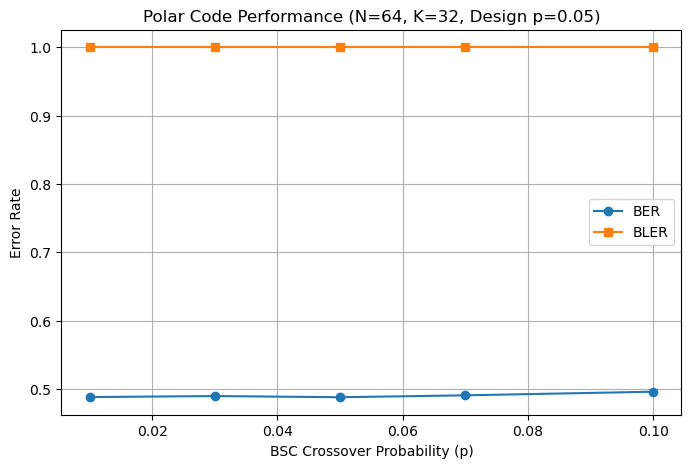

([0.48796875, 0.48946875, 0.48775, 0.49053125, 0.4958125],
 [1.0, 1.0, 1.0, 1.0, 1.0])

In [6]:
N = 64
K = 32
p_design = 0.05
p_channel = 0.05
ber, bler = monte_carlo(N, K, p_design, p_channel, trials=1000, verbose=False)
print(f"Final Results - BER: {ber}, BLER: {bler}")
p_values = [0.01, 0.03, 0.05, 0.07, 0.10]
monte_carlo_curve(p_values, N, K, p_design, trials=1000)